# Overview

This notebook presents the usage of a LSTM (Long Short Term Memory) network in order to produce the required 21 day forecast.

Note: Exact results may not be reproducible.

# Data Pre-processing

After preliminary data exploration, the possible errorneous/irrelevant transactions are removed. This includes transactions with prices which do not make sense and negative quantities which do not represent refunds. The sales are then aggregated according to the invoice date, creating a univariate time series. Gaps in the sales data are filled in using interpolation.

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
##############Cleaning###########
#Read CSV
df = pd.read_csv('train_data.csv')

#Process Dates
df['ds']= df.InvoiceDate.apply(lambda x: datetime.strptime(x[:10],'%d/%m/%Y'))

#Remove weird prices
df = df[(df['UnitPrice']> 0) & (df['UnitPrice'] < 1000)]

#Remove negative quantities that are not refunds
remove = (df['Quantity'] < 0) & (df['InvoiceNo'].str.find('C') == -1)
df = df[np.logical_not(remove)]

In [3]:
#Aggregate sales per day
daily = df['Quantity'].groupby(df['ds']).sum()
daily = pd.DataFrame(daily)
daily.columns = ['y']

In [4]:
#Fill missing values in date range using interpolation
idx = pd.date_range('2010-12-01', '2011-11-18')
daily = daily.reindex(idx, fill_value= None)
daily['y'].interpolate(method='time', inplace=True)

In [5]:
#Export for easy access
#daily.to_csv('daily_time.csv')

# Forecasting

A two-layer LSTM (Long Short Term Memory) network to produce the forecast. There are several reasons for this choice:
- Traditional statistical forecasting methods such as ARIMA were explored, but initial results were generally inferior. 
- This could be due to the large forecast period, which is less suitable for the recursive one-step forecast approach.
- A RNN type architecture can represent sequenced time series data, while LSTMs can capture the long-range dependencies.
- Additional features can be introduced through feature engineering or other methods.

The LSTM network is used to produce a direct 21 day ahead forecast instead of single-step forecasts. A sliding window method is used, where the past 30 days data is used to produce the forecast. Time series features, such as the day of the week, are also created and used to attempt to capture possible seasonality/trend. 

In [2]:
#Read previously cleaned data
daily = pd.read_csv('daily_time.csv')
daily.columns = ['ds','y']
daily['ds'] = pd.to_datetime(daily['ds'])
daily = daily.set_index('ds')

In [3]:
#Create time series features
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df['ds'] = df.index
    df['dayofweek'] = df['ds'].dt.dayofweek
    df['quarter'] = df['ds'].dt.quarter
    df['month'] = df['ds'].dt.month
    df['dayofmonth'] = df['ds'].dt.day
    df['dayofyear'] = df['ds'].dt.dayofyear
    df['weekofyear'] = df['ds'].dt.weekofyear
    
    return df

daily = create_features(daily)
daily.drop('ds', axis = 1, inplace= True)
original = daily.copy()

In [4]:
#Produce 21 day ahead volumes for training
fc_period = 21

def create_horizon(df,max_lag):
    lags = range(1, max_lag + 1)
    for lag in lags:
        df['y' + str(lag)] = df['y'].shift(-lag)
    
    #Discard rows with invalid lag
    df = df.iloc[:len(df) - max_lag]
    return df

daily = create_horizon(daily,fc_period)
daily

,y,dayofweek,quarter,month,dayofmonth,dayofyear,weekofyear,y1,y2,y3,...,y12,y13,y14,y15,y16,y17,y18,y19,y20,y21
ds,,,,,,,,,,,,,,,,,,,,,
2010-12-01,26736.0,2,4,12,1,335,48,30402.0,15908.0,16151.0,...,17624.0,19655.0,18234.0,29628.0,16057.0,9926.0,3795.0,14112.000000,15422.000000,3058.000000
2010-12-02,30402.0,3,4,12,2,336,48,15908.0,16151.0,16394.0,...,19655.0,18234.0,29628.0,16057.0,9926.0,3795.0,14112.0,15422.000000,3058.000000,5684.000000
2010-12-03,15908.0,4,4,12,3,337,48,16151.0,16394.0,21496.0,...,18234.0,29628.0,16057.0,9926.0,3795.0,14112.0,15422.0,3058.000000,5684.000000,5910.916667
2010-12-04,16151.0,5,4,12,4,338,48,16394.0,21496.0,25120.0,...,29628.0,16057.0,9926.0,3795.0,14112.0,15422.0,3058.0,5684.000000,5910.916667,6137.833333
2010-12-05,16394.0,6,4,12,5,339,48,21496.0,25120.0,22819.0,...,16057.0,9926.0,3795.0,14112.0,15422.0,3058.0,5684.0,5910.916667,6137.833333,6364.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-10-24,21927.0,0,4,10,24,297,43,26668.0,20774.0,32327.0,...,28777.5,23295.0,30676.0,26054.0,36293.0,38017.0,28749.0,24552.000000,20355.000000,47160.000000
2011-10-25,26668.0,1,4,10,25,298,43,20774.0,32327.0,24041.0,...,23295.0,30676.0,26054.0,36293.0,38017.0,28749.0,24552.0,20355.000000,47160.000000,30316.000000
2011-10-26,20774.0,2,4,10,26,299,43,32327.0,24041.0,22051.5,...,30676.0,26054.0,36293.0,38017.0,28749.0,24552.0,20355.0,47160.000000,30316.000000,31958.000000


In [5]:
#Scale data before feeding into network to avoid exploding/vanishing gradients
from sklearn.preprocessing import MinMaxScaler

xscaler = MinMaxScaler(feature_range=(0, 1))

xdata = xscaler.fit_transform(daily.values[:,0:7])

yscaler = MinMaxScaler(feature_range=(0, 1))

ydata = yscaler.fit_transform(daily.values[:,7:])

In [6]:
#Create windows from data
#Each row of X has shape (#days that form the window, #features) = (#30, 7)
#Each row of Y contains corresponding 21 dimension vector containing 21 days ahead volume
x, y = [],[]
window_size = 30

for i in range(window_size, xdata.shape[0]):
    x.append(xdata[i-window_size:i, ])
    y.append(ydata[i,])

In [7]:
#Training/Test Set Split
test_size = 100
x = np.array(x)
y = np.array(y)

def seperate(x):
    train = x[:x.shape[0] - test_size,]
    test = x[x.shape[0] - test_size:,]
    return train, test

x_train, x_test = seperate(x)
y_train, y_test = seperate(y)

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout,LSTM
from keras.optimizers import Adam

Using TensorFlow backend.


Train on 202 samples, validate on 100 samples
Epoch 1/30
202/202 [==============================] - 1s 3ms/step - loss: 0.0962 - val_loss: 0.1984
Epoch 2/30
202/202 [==============================] - 0s 693us/step - loss: 0.0782 - val_loss: 0.1637
Epoch 3/30
202/202 [==============================] - 0s 703us/step - loss: 0.0646 - val_loss: 0.1330
Epoch 4/30
202/202 [==============================] - 0s 718us/step - loss: 0.0552 - val_loss: 0.1073
Epoch 5/30
202/202 [==============================] - 0s 673us/step - loss: 0.0477 - val_loss: 0.0872
Epoch 6/30
202/202 [==============================] - 0s 718us/step - loss: 0.0453 - val_loss: 0.0761
Epoch 7/30
202/202 [==============================] - 0s 718us/step - loss: 0.0414 - val_loss: 0.0737
Epoch 8/30
202/202 [==============================] - 0s 678us/step - loss: 0.0391 - val_loss: 0.0754
Epoch 9/30
202/202 [==============================] - 0s 673us/step - loss: 0.0381 - val_loss: 0.0764
Epoch 10/30
202/202 [=================

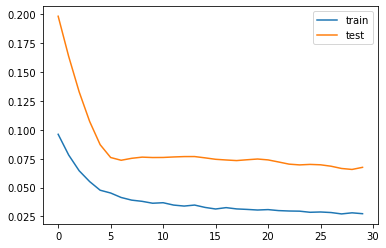

In [9]:
#Train LSTM
model = Sequential()
model.add(LSTM(units=160,input_shape=(x_train.shape[1],x_train.shape[2]),return_sequences=True))
model.add(LSTM(units=64))
model.add(Dropout(0.5))
model.add(Dense(21)) #FC Layer for forecast
ADAM = Adam(0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer=ADAM)
history = model.fit(x_train,y_train,epochs=30,batch_size=120,validation_data=(x_test,y_test),verbose=1,shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [10]:
#Feed last window from training data to get forecasts
from numpy import newaxis
last_day = original.iloc[len(original)- 1 - window_size:len(original)-1,:]
last_scaled = xscaler.transform(last_day)
last_scaled = last_scaled[newaxis, :, :]
pred = model.predict(last_scaled)

In [11]:
#Scale forecasts back to original scale
pred_scale = yscaler.inverse_transform(pred)

In [12]:
#Obtained forecast
pred_scale

array([[16543.162 , 14710.286 , 13091.095 , 13748.142 , 14310.659 ,
        15097.999 , 14108.449 , 13667.822 , 12552.84  , 14626.937 ,
        15314.6875, 15236.821 , 12147.967 , 12702.157 , 13149.749 ,
        10861.614 , 12859.356 , 13534.13  , 14677.435 , 13913.7295,
        11756.427 ]], dtype=float32)

In [16]:
#Generate required format for submission
output = pd.date_range('2011-11-19', '2011-12-09')
output = pd.DataFrame(output)
output.columns = ['Date']

y_pred = [int(pred) for pred in pred_scale[0]] #Round down to integers for submission

output['Quantity'] = y_pred

#Export csv for submission
#output.to_csv('lstmv3.csv',index=False)